In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from kan import KAN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

# Fault Detection
In this notebook we'll train a `PyKAN` network to distinguish between *faulty* and *not-faulty* operating regimes.

## Load dataset

In [ ]:
df_x = pd.read_csv('../dataset/X_train.csv')
df_y = pd.read_csv('../dataset/y_train.csv')

df = df_x.merge(df_y[['id', 'faulty', 'trq_margin']], on='id')

features = ['trq_measured', 'oat', 'mgt', 'pa', 'ias', 'np', 'ng', 'trq_margin']
target = 'faulty'

X = df[features].values
y = df[target].values

In [ ]:
# Sampling 10%
sample_fraction = 0.1
X_sample, _, y_sample, _ = train_test_split(X, y, test_size=(1-sample_fraction), stratify=y, random_state=42)

# Divisione 80/20
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, stratify=y_sample, random_state=42)

# Normalizzazione
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# With CrossEntropyLoss

In [ ]:
# Conversione in tensori
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.long).to(device)

In [ ]:
# Inizializzazione
#model = KAN(width=[8, 10, 2], grid=5, k=3, seed=42).to(device)
model = KAN(width=[8, 5, 2], grid=5, k=3, seed=42).to(device)

# Funzioni per il training
def train_acc():
    preds = torch.argmax(model(X_train_t), dim=1)
    return torch.mean((preds == y_train_t).float())

def test_acc():
    preds = torch.argmax(model(X_test_t), dim=1)
    return torch.mean((preds == y_test_t).float())

# Training
model.fit(
    {'train_input': X_train_t, 'train_label': y_train_t,
     'test_input': X_test_t, 'test_label': y_test_t},
    opt="LBFGS", steps=50, loss_fn=torch.nn.CrossEntropyLoss(),
    lamb=0.001, metrics=(train_acc, test_acc), update_grid=False
)

# Valutazione su test set
with torch.no_grad():
    output = model(X_test_t)
    probs = torch.softmax(output, dim=1)
    y_pred = torch.argmax(probs, dim=1).cpu().numpy()

# Metriche
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)

print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.63e-01 | test_loss: 1.84e-01 | reg: 3.15e+01 | : 100%|█| 50/50 [00:35<00:00,  1.41it

saving model version 0.1
Accuracy:  0.988
Precision: 0.986
Recall:    0.985
F1-score:  0.986


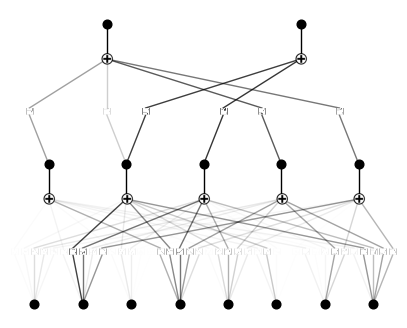

In [ ]:
model.plot()

In [ ]:
print("unique values:", np.unique(y_train))

unique values: [0 1]


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

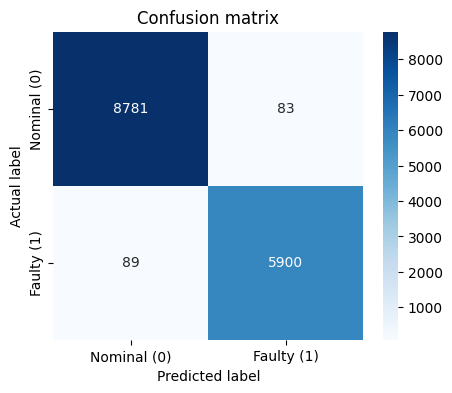

In [ ]:
# Matrice di confusione
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Nominal (0)", "Faulty (1)"], yticklabels=["Nominal (0)", "Faulty (1)"])
plt.xlabel("Predicted label")
plt.ylabel("Actual label")
plt.title("Confusion matrix")
plt.show()

# With BCE

In [ ]:
# Conversione in tensori
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

In [ ]:
# Inizializzazione
model = KAN(width=[8, 5, 1], grid=5, k=3, seed=42).to(device)

def train_acc():
    outputs = model(X_train_t)
    preds = (torch.sigmoid(outputs) > 0.5).float()
    return torch.mean((preds == y_train_t).float())

def test_acc():
    outputs = model(X_test_t)
    preds = (torch.sigmoid(outputs) > 0.5).float()
    return torch.mean((preds == y_test_t).float())

# Training usando BCEWithLogitsLoss
model.fit(
    {'train_input': X_train_t, 'train_label': y_train_t,
     'test_input': X_test_t, 'test_label': y_test_t},
    opt="LBFGS", steps=50, loss_fn=torch.nn.BCEWithLogitsLoss(),
    lamb=0.001, metrics=(train_acc, test_acc), update_grid=False
)

# Valutazione sul test set
with torch.no_grad():
    output = model(X_test_t)
    probs = torch.sigmoid(output)
    y_pred = (probs > 0.5).int().cpu().numpy().flatten()

# Metriche
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)

print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.89e-01 | test_loss: 2.02e-01 | reg: 3.00e+01 | : 100%|█| 50/50 [00:34<00:00,  1.45it

saving model version 0.1
Accuracy:  0.985
Precision: 0.984
Recall:    0.980
F1-score:  0.982


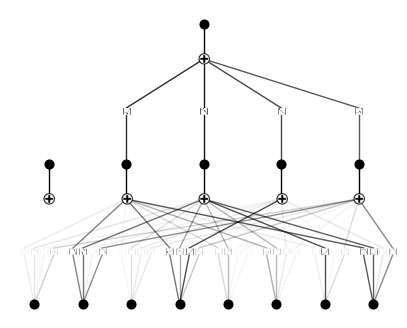

In [ ]:
model.plot()

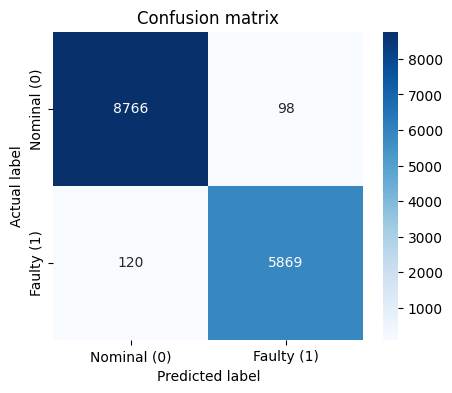

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Nominal (0)", "Faulty (1)"], yticklabels=["Nominal (0)", "Faulty (1)"])
plt.xlabel("Predicted label")
plt.ylabel("Actual label")
plt.title("Confusion matrix")
plt.show()